In [10]:
import requests
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import seaborn as sns
import pandas as pd
import panel as pn
import matplotlib.pyplot as plt

### The objective of this project is to develop a sentiment analysis system tailored to financial news articles, with the goal of automatically classifying news content as positive, negative, or neutral in relation to financial markets. By leveraging pre-trained transformer models (such as BERT) and fine-tuning on finance-specific text data, the system aims to provide real-time sentiment insights that can assist investors, analysts, and financial institutions in understanding market sentiment, assessing risk, and making more informed decisions.

# bert with newsapi (24hr lag)

In [46]:
def sentiment_news(keyword, date):
    keyword =keyword
    date= date
    API_KEY= '73be7bbcb0de4667be7e690711184333'

    url= (f'https://newsapi.org/v2/everything?'
    f'q= {keyword}&'
    f'from={date}&'
    'sortBy=popularity&'
    f'pageSize=100&'
    f'apikey={API_KEY}'
     )

    response = requests.get(url)


    articles =response.json()


    articles= articles['articles']
    df= pd.DataFrame(articles) #convert to dataframe
    df["publishedAt"] = pd.to_datetime(df["publishedAt"]).dt.date
    return df

In [59]:
def sentiment_dashboard(df):

    #load model and tokenizer

    model_name= "nlptown/bert-base-multilingual-uncased-sentiment" #name of the model that will be used
    tokenizer=AutoTokenizer.from_pretrained(model_name) #breaks text into pieces
    model= AutoModelForSequenceClassification.from_pretrained(model_name) #load already trained model from Hugging Face

    def analyze_sentiment(text):
        #tokenize and prepare input
        inputs= tokenizer(text, return_tensors='pt', truncation= True, padding=True) #convert text into tokens
    
        with torch.no_grad(): #tells pytorch that the model is just for predictions with no training
            outputs=model(**inputs)
    
        #get predicted sentiment
        sentiment_scores= outputs.logits #returns raw scores for each class
        predicted_class= torch.argmax(sentiment_scores, dim=1).item() #pickes the class with the highest score
    
        #return the sentiment as numeric value from 1 to 5
        sentiment_value = predicted_class +1 #To convert zero indexed to 1 indexed
        return sentiment_value

    
    #add new column for sentiment analysis results
    df['sentiment'] = df['content'].apply(analyze_sentiment)

    #sentiment label

    sentiment_labels= ['very negative', 'negative', 'neutral', 'postive', 'very positive']

    def get_sentiment_label(score):
        #Since the sentiment scores are 1-based and sentiment labels are zero_based
        return sentiment_labels[score-1]

    #add new column for sentiment labels
    df["sentiment_label"] =df['sentiment'].apply(get_sentiment_label)



    pn.extension()

    # Example DataFrame (replace with your real data)


    # 📊 Plot 1: Sentiment over time
    def plot_sentiment():
        fig, ax = plt.subplots()
        sns.set_style('whitegrid')
        sns.set_palette('pastel')

        sns.countplot(data=df, x='sentiment_label', order= sentiment_labels, ax=ax)
        plt.title("Sentiment Score Distribution")
        plt.xlabel("Sentiment Score")
        plt.ylabel("Frequency")

        return pn.pane.Matplotlib(fig)

    
    latest_date = df['publishedAt'].max()
    latest_article = df[df['publishedAt'] == latest_date]
    def plot_sentiment_currently():
        fig, ax = plt.subplots()
        sns.set_style('whitegrid')
        sns.set_palette('pastel')
    
        sns.countplot(data=latest_article, x='sentiment_label', order= sentiment_labels, ax=ax)
        plt.title("Sentiment Score Distribution")
        plt.xlabel(f"Sentiment Score for {latest_date}")
        plt.ylabel("Frequency")
    
        return pn.pane.Matplotlib(fig)
    
    # 🧾 Table
    table = pn.widgets.DataFrame(df[['title','description']], width=1200, height=200)
    
    # 🧩 Combine into dashboard
    dashboard = pn.Column(
        "# 🔥 Live Dashboard",
        f"Last updated: {df['publishedAt'].max()}",
        plot_sentiment(),
        plot_sentiment_currently(),
        table
    )
    # 💾 Save to HTML
    dashboard.save('sentiment.html2', embed=True)

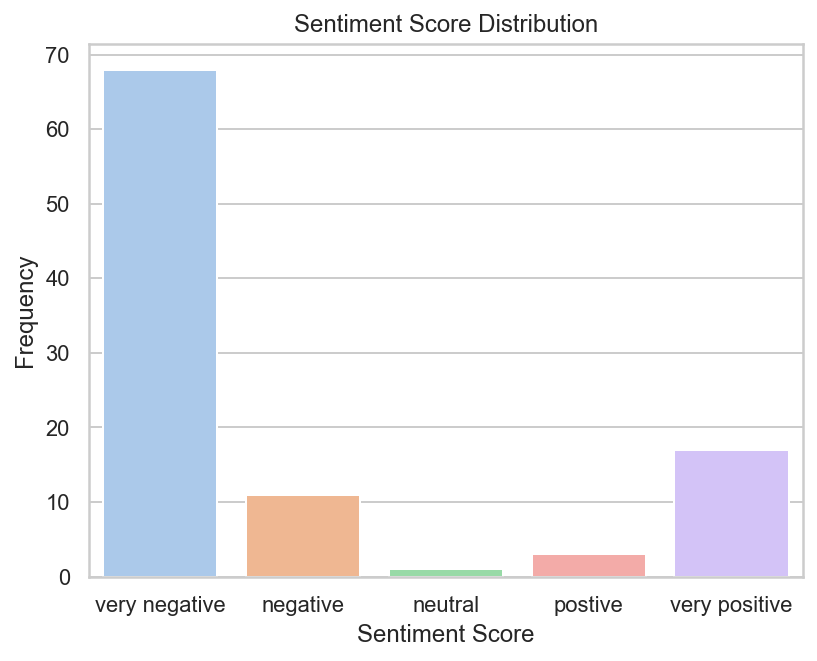

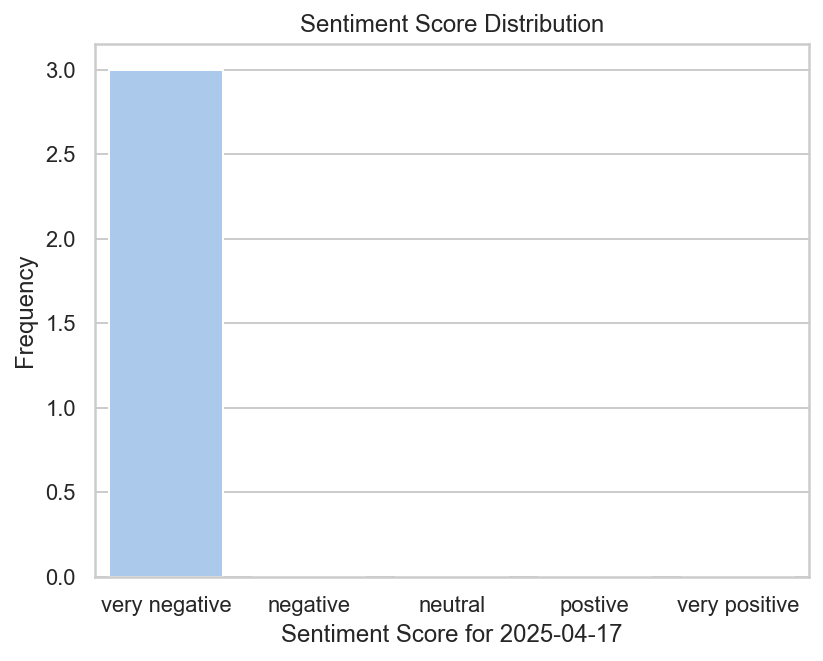

In [60]:

keyword='Nasdaq'
date='2025-03-21' #what date to start the analysis
sentiment_dashboard(sentiment_news(keyword, date))

# bert Yahoo finance

In [53]:
def get_news(keyword):
    import requests

    url = "https://yahoo-finance15.p.rapidapi.com/api/v2/markets/news"
    
    querystring = {"q":f"{keyword}","type":"ALL"}
    
    headers = {
    	"x-rapidapi-key": "d2a3c6b2c5mshcf94668ef15034fp139c75jsn487e8d5d03ab",
    	"x-rapidapi-host": "yahoo-finance15.p.rapidapi.com"
    }
    
    response = requests.get(url, headers=headers, params=querystring)
    
    articles_pipe= response.json()
    articles_pipe.keys()
    df= pd.DataFrame(articles_pipe['body']) 
    return df

def sentiment(df):

    #load model and tokenizer
    
    model_name= "nlptown/bert-base-multilingual-uncased-sentiment" #name of the model that will be used
    tokenizer=AutoTokenizer.from_pretrained(model_name) #breaks text into pieces
    model= AutoModelForSequenceClassification.from_pretrained(model_name) #load already trained model from Hugging Face

    def analyze_sentiment(text):
        #tokenize and prepare input
        inputs= tokenizer(text, return_tensors='pt', truncation= True, padding=True) #convert text into tokens
    
        with torch.no_grad(): #tells pytorch that the model is just for predictions with no training
            outputs=model(**inputs)
    
        #get predicted sentiment
        sentiment_scores= outputs.logits #returns raw scores for each class
        predicted_class= torch.argmax(sentiment_scores, dim=1).item() #pickes the class with the highest score
    
        #return the sentiment as numeric value from 1 to 5
        sentiment_value = predicted_class +1 #To convert zero indexed to 1 indexed
        return sentiment_value

    df['sentiment'] = df['text'].apply(analyze_sentiment)

    sentiment_labels= ['very negative', 'negative', 'neutral', 'postive', 'very positive']
    
    def get_sentiment_label(score):
        #Since the sentiment scores are 1-based and sentiment labels are zero_based
        return sentiment_labels[score-1]
    
    #add new column for sentiment labels
    df["sentiment_label"] =df['sentiment'].apply(get_sentiment_label)


    #set style and color
    sns.set_style('whitegrid')
    sns.set_palette('pastel')
    
    sns.countplot(data=df, x='sentiment_label', order= sentiment_labels)
    plt.title("Sentiment Score Distribution")
    plt.xlabel(f"Sentiment Score : {df['time'].max()}")
    plt.ylabel("Frequency")
    
    
    plt.show()
        

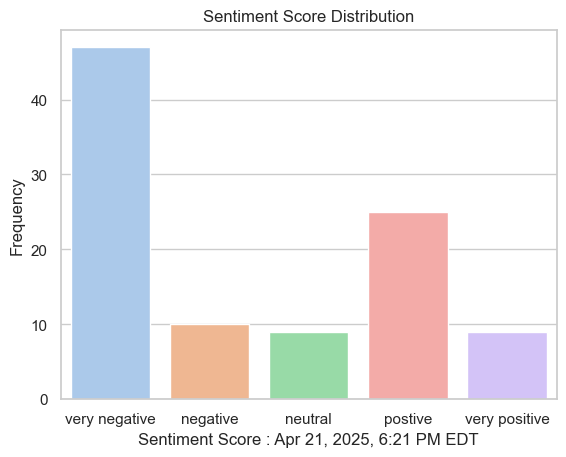

In [54]:
sentiment(get_news('S&P 500'))


# ProsusAI/finbert Yahoo finance


In [55]:
from transformers import pipeline
df_pipe= get_news('AAPL')

def pipe_sentiment(df):

    pipe= pipeline(task= 'text-classification' , model = 'ProsusAI/finbert')
    
    sentiment_label=[]
    sentiment_scores=[]
        
    for i in range(0,100):
        text= df_pipe['text'][i]
        result_label= pipe(text)[0]['label']
        result_score= pipe(text)[0]['score']
        sentiment_label.append(result_label)
        sentiment_scores.append(result_score)

        


    
    df_pipe['sentiment_label']= sentiment_label
    df_pipe['sentiment_score']= sentiment_scores

    order= ['negative', 'neutral', 'positive'] 
    
    #set the plot style
    sns.set()
    sns.set_style('whitegrid')
    sns.color_palette('husl')
    
    #plot Histogram
    sns.countplot(x='sentiment_label', data=df_pipe, order = order, palette= 'Greens_d')
    plt.title('Sentiment Analysis using Finbert')
    plt.xlabel(f'Sentiment: {date}')
    plt.ylabel('Frequency')



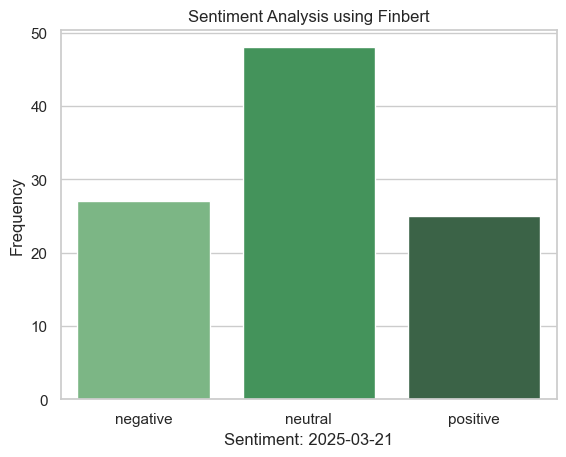

In [56]:
pipe_sentiment(df_pipe)